## 📊 Simulación

🧑‍💻 Lucía Cordero | Jorge Garcelán

![Election Results](https://elordenmundial.com/wp-content/uploads/2020/10/editable-portada-especial-.png)


<div class="warning" style='padding:0.1em; border-left: 4px solid #17a2b8; background-color:#e8f8ff;'>
<span>
<p style='margin-top:1em; margin-left:1em; text-align:left'>
<b>💡Interpretación de la simulación</b></p>
<p style='margin-left:1em;'>
Imaginemos que estamos en el día de las elecciones y nos van llegando datos de condados (equivalentes a dataset de train) y queremos hacer un forecast de cómo van a acabar las elecciones, es decir, hacer un forecast de los condados que todavía no tenemos los datos (test). En ese sentido, podríamos hacer un modelo con los datos que sí tenemos (train) y predecir los condados que todavía no tenemos (test). Y así podemos repetir el proceso N veces y crear una simulación.
</p>
</span>
</div>

## Libraries

In [51]:
import pandas as pd
from pandas import read_csv
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import json
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

## Load data

In [52]:
CENSUS_YEAR = 2023
ELECTORAL_YEAR = CENSUS_YEAR + 1


In [53]:
def load_seats_data(path, state_to_code):
    # Cargar datos
    seats_data = pd.read_csv(path, header=0, sep=",")

    # Seleccionar las primeras tres columnas y las columnas que contienen "2019"
    seats_data = seats_data.iloc[:, [0, 1]]

    # Renombrar columnas
    seats_data.columns = ["state", "electoral_votes_number"]

    # Añadir District of Columbia pues no aparece
    new_row = pd.DataFrame({
        'state': ['District of Columbia'],
        'electoral_votes_number': [3]
    })

    # Añadir la nueva fila al DataFrame utilizando pd.concat
    seats_data = pd.concat([seats_data, new_row], ignore_index=True)

    
    seats_data["state_code"] = seats_data['state'].map(state_to_code)

    return seats_data

In [54]:
# Cargar datos
data = read_csv(f"data/final_data_{ELECTORAL_YEAR}.csv")

# Crear data para simulación
# columns_to_drop = ['Total_2020', 'Other_2020', 'Winner_2020', "Biden_2020"]  # Nombres de las columnas a eliminar
columns_to_drop = [f"votes_dem_{ELECTORAL_YEAR}", f"total_votes_{ELECTORAL_YEAR}", f"votes_others_{ELECTORAL_YEAR}", f"per_votes_others_{ELECTORAL_YEAR}", f"winner_{ELECTORAL_YEAR}"]  # Nombres de las columnas a eliminar

data_sim = data.drop(columns=columns_to_drop)

# Cargar codigo de estados
with open("data/state_to_code.json", "r") as file:
    state_to_code = json.load(file)


# Cargar datos de escaños por estado
seats_data = load_seats_data(f"data/seats2020.csv", state_to_code)

# Cargar datos de state, county, fips
state_fips_county = read_csv('data/state_fips_county.csv')
state_names = state_fips_county['state']
fips_codes = state_fips_county['fips']
county_names = state_fips_county['county']

In [55]:
# Cargar datos electorales reales
df_actual = pd.DataFrame({f'Votes_dem': data[f'votes_dem_{ELECTORAL_YEAR}'], 
                            f'Votes_gop': data[f'total_votes_{ELECTORAL_YEAR}'] - data[f'votes_dem_{ELECTORAL_YEAR}'] - data[f'votes_others_{ELECTORAL_YEAR}'], 
                            f'Votes_other': data[f'votes_others_{ELECTORAL_YEAR}'],
                            f'Votes_total': data[f'total_votes_{ELECTORAL_YEAR}'], 
                            'state': state_names,
                            'county': county_names,
                            'fips': fips_codes})
df_actual_state = df_actual.groupby('state').agg(Votes_dem=(f'Votes_dem', 'sum'), 
                                                    Votes_gop=(f'Votes_gop', 'sum'),
                                                    Votes_other=(f'Votes_other', 'sum'),
                                                    Votes_total=(f'Votes_total', 'sum'))

df_actual_state["Per_dem"] = df_actual_state["Votes_dem"] / df_actual_state["Votes_total"]
df_actual_state["Per_gop"] = df_actual_state["Votes_gop"] / df_actual_state["Votes_total"]

# Añadir la columna "Winner" basado en los porcentajes predichos de Biden y Trump
df_actual_state["Winner"] = np.where(df_actual_state["Per_dem"] < df_actual_state["Per_gop"], 'gop', 'dem')


full_df_actual_state = pd.merge(seats_data, df_actual_state, how='inner', on=["state"])



# Añadir diferencia entre Biden y Trump
full_df_actual_state['Difference'] = (full_df_actual_state["Per_dem"] - full_df_actual_state["Per_gop"]) * 100


# Definir las condiciones y los valores a asignar
conditions = [
    full_df_actual_state["Difference"] > 10,
    full_df_actual_state["Difference"].between(2.5, 10),
    full_df_actual_state["Difference"].between(-2.5, 2.5),
    full_df_actual_state["Difference"].between(-10, -2.5),
    full_df_actual_state["Difference"] < -10
]

choices = [
    "Safe Democrat",
    "Likely Democrat",
    "Toss-Up",
    "Likely Republican",
    "Safe Republican"
]

# Usar np.select para asignar el "Status" basado en las condiciones, con un valor por defecto "Unknown"
full_df_actual_state["Status"] = np.select(conditions, choices, default="Unknown")

full_df_actual_state

,state,electoral_votes_number,state_code,Votes_dem,Votes_gop,Votes_other,Votes_total,Per_dem,Per_gop,Winner,Difference,Status
0,California,55,CA,9276179.0,6081697.0,504660.0,15862536.0,0.584785,0.383400,dem,20.138533,Safe Democrat
1,Texas,38,TX,4832009.0,6380781.0,151174.0,11363964.0,0.425205,0.561493,gop,-13.628801,Safe Republican
2,New York,29,NY,4567230.0,3572276.0,1007.0,8140513.0,0.561049,0.438827,dem,12.222252,Safe Democrat
3,Florida,29,FL,4683038.0,6110125.0,100384.0,10893547.0,0.429891,0.560894,gop,-13.100297,Safe Republican
4,Pennsylvania,20,PA,3420658.0,3513108.0,67907.0,7001673.0,0.488549,0.501753,gop,-1.320399,Toss-Up
5,Illinois,20,IL,3057931.0,2436446.0,80206.0,5574583.0,0.548549,0.437063,dem,11.148547,Safe Democrat
6,Ohio,18,OH,2532890.0,3175707.0,51247.0,5759844.0,0.439750,0.551353,gop,-11.160320,Safe Republican
7,Michigan,16,MI,2737917.0,2818120.0,109405.0,5665442.0,0.483266,0.497423,gop,-1.415653,Toss-Up
8,Georgia,16,GA,2548017.0,2663117.0,38913.0,5250047.0,0.485332,0.507256,gop,-2.192361,Toss-Up
9,North Carolina,15,NC,2674966.0,2851448.0,64856.0,5591270.0,0.478418,0.509982,gop,-3.156385,Likely Republican


## Algorithm

In [56]:
n_sim = 500

In [57]:
# Inicializar un DataFrame para guardar los resultados de las simulaciones
# simulation_results = pd.DataFrame(columns=['Pred_dem', 'Pred_gop', 'dem', 'gop'])
simulation_results = pd.DataFrame(columns=['Pred_dem', 'Pred_gop'])


# Inicializar un DataFrame para acumular los resultados por estado
accumulated_pred_state = pd.DataFrame()

for i in range(0, n_sim):

    print(f"Simulation {i}")

    ## Data splitting
    # Quitar la columna objetivo (f'per_dem_{ELECTORAL_YEAR}') del conjunto de datos
    X = data_sim.drop(columns=[f'per_dem_{ELECTORAL_YEAR}'])  # Características (sin la columna objetivo)
    y = data_sim[f'per_dem_{ELECTORAL_YEAR}']  # Columna objetivo

    # Dividir los datos en 80% para train y 20% para test (cada sim es distinto)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    ## Models
    # Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    pred_lr = lr_model.predict(X_test)

    # Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=i)
    rf_model.fit(X_train, y_train)
    pred_rf = rf_model.predict(X_test)

    # KNN
    knn_model = KNeighborsRegressor(n_neighbors=5)  # Puedes ajustar el número de vecinos
    knn_model.fit(X_train, y_train)
    pred_knn = knn_model.predict(X_test)

    # Predicciones combinadas
    predictions = (pred_lr + pred_rf + pred_knn) / 3  # Promedio de predicciones de los tres modelos

    # Todos los votos por condado, pero usando predicciones
    per_dem_pred = data[f'per_dem_{ELECTORAL_YEAR}'].copy()
    per_dem_pred.iloc[X_test.index] = predictions

    # Agrupar por estado para calcular las predicciones por estado
    df_pred = pd.DataFrame({'Votes_dem': per_dem_pred * data[f'total_votes_{ELECTORAL_YEAR}'], 
                            'Votes_gop': (1 - per_dem_pred - data[f'per_votes_others_{ELECTORAL_YEAR}']) * data[f'total_votes_{ELECTORAL_YEAR}'],
                            'Votes_other':  data[f'votes_others_{ELECTORAL_YEAR}'],
                            'Votes_total': data[f'total_votes_{ELECTORAL_YEAR}'], 
                            'state': state_names,
                            'county': county_names,
                            'fips': fips_codes})
    df_pred_state = df_pred.groupby('state').agg(Votes_dem=("Votes_dem", 'sum'), 
                                                 Votes_gop=("Votes_gop", 'sum'),
                                                 Votes_other=("Votes_other", 'sum'),
                                                 Votes_total=("Votes_total", 'sum'))
    
    
    # Calcular porcentaje de cada candidato en el estado
    df_pred_state["Per_dem"] = df_pred_state["Votes_dem"] / df_pred_state["Votes_total"] + 1/2*(df_pred_state["Votes_other"] / df_pred_state["Votes_total"]) # asumimos que el voto a "otros" se reparte por igual para biden y trump
    df_pred_state["Per_gop"] = 1 - df_pred_state["Per_dem"]

    # Acumular los resultados de cada simulación
    if accumulated_pred_state.empty:
        accumulated_pred_state = df_pred_state.copy()  # Primera iteración, simplemente copiamos los datos
    else:
        accumulated_pred_state['Votes_dem'] += df_pred_state['Votes_dem']
        accumulated_pred_state['Votes_gop'] += df_pred_state['Votes_gop']
        accumulated_pred_state['Votes_total'] += df_pred_state['Votes_total']
        accumulated_pred_state["Per_dem"] += df_pred_state["Per_dem"]
        accumulated_pred_state["Per_gop"] += df_pred_state["Per_gop"]

    # Predicción y ganadores
    df_pred_state["Winner"] = np.where(df_pred_state["Per_dem"] < df_pred_state["Per_gop"], 'gop', 'dem')    

    # Añadir votos electorales (escaños) a cada estado
    full_df_pred_state = pd.merge(seats_data, df_pred_state, how='inner', on=["state"])

    # Agrupar por estado y sumar los votos
    df_pred_winner = full_df_pred_state.groupby("Winner").agg({
        "electoral_votes_number": "sum",  # Sumar los votos electorales de cada candidato
    }).reset_index()

    df_pred_winner.loc[df_pred_winner["Winner"] == 'gop', 'electoral_votes_number'] += 3 # Añadir 3 al número de votos electorales de Trump por Alaska

    # Crear un nuevo DataFrame con los resultados de esta simulación
    new_row = pd.DataFrame({
        'Pred_dem': [df_pred_winner.loc[df_pred_winner["Winner"] == 'dem', 'electoral_votes_number'].values[0]],
        'Pred_gop': [df_pred_winner.loc[df_pred_winner["Winner"] == 'gop', 'electoral_votes_number'].values[0]],
        'Winner': ['dem' if df_pred_winner.loc[df_pred_winner["Winner"] == 'dem', 'electoral_votes_number'].values[0] > df_pred_winner.loc[df_pred_winner["Winner"] == 'gop', 'electoral_votes_number'].values[0] else 'gop']
    })

    # Usar concat para añadir la nueva fila
    simulation_results = pd.concat([simulation_results, new_row], ignore_index=True)

# Después de todas las simulaciones, calcular la media
accumulated_pred_state['Votes_dem'] /= n_sim
accumulated_pred_state['Votes_gop'] /= n_sim
accumulated_pred_state['Votes_total'] /= n_sim
accumulated_pred_state['Per_dem'] /= n_sim
accumulated_pred_state['Per_gop'] /= n_sim


Simulation 0
Simulation 1
Simulation 2
Simulation 3
Simulation 4
Simulation 5
Simulation 6
Simulation 7
Simulation 8
Simulation 9
Simulation 10
Simulation 11
Simulation 12
Simulation 13
Simulation 14
Simulation 15
Simulation 16
Simulation 17
Simulation 18
Simulation 19
Simulation 20
Simulation 21
Simulation 22
Simulation 23
Simulation 24
Simulation 25
Simulation 26
Simulation 27
Simulation 28
Simulation 29
Simulation 30
Simulation 31
Simulation 32
Simulation 33
Simulation 34
Simulation 35
Simulation 36
Simulation 37
Simulation 38
Simulation 39
Simulation 40
Simulation 41
Simulation 42
Simulation 43
Simulation 44
Simulation 45
Simulation 46
Simulation 47
Simulation 48
Simulation 49
Simulation 50
Simulation 51
Simulation 52
Simulation 53
Simulation 54
Simulation 55
Simulation 56
Simulation 57
Simulation 58
Simulation 59
Simulation 60
Simulation 61
Simulation 62
Simulation 63
Simulation 64
Simulation 65
Simulation 66
Simulation 67
Simulation 68
Simulation 69
Simulation 70
Simulation 71
Si

## Results

In [69]:
simulation_results["Winner"].value_counts()

Winner
gop    500
Name: count, dtype: int64

In [70]:
simulation_results["Winner"].value_counts(normalize=True)

Winner
gop    1.0
Name: proportion, dtype: float64

In [71]:
simulation_results

,Pred_dem,Pred_gop,Winner
0,222,316,gop
1,227,311,gop
2,227,311,gop
3,227,311,gop
4,227,311,gop
...,...,...,...
495,238,300,gop
496,227,311,gop
497,227,311,gop
498,227,311,gop


In [61]:
# Añadir la columna "Winner" basado en los porcentajes predichos de Biden y Trump
accumulated_pred_state['Winner'] = np.where(
    accumulated_pred_state["Per_dem"] >= accumulated_pred_state["Per_gop"], 'dem', 'gop'
)

# Añadir los códigos de los estados usando el diccionario state_to_code
accumulated_pred_state['state_code'] = accumulated_pred_state.index.map(state_to_code)

# Añadir diferencia entre Biden y Trump
accumulated_pred_state['Difference'] = (accumulated_pred_state["Per_dem"] - accumulated_pred_state["Per_gop"]) * 100


# Definir las condiciones y los valores a asignar
conditions = [
    accumulated_pred_state["Difference"] > 10,
    accumulated_pred_state["Difference"].between(2.5, 10),
    accumulated_pred_state["Difference"].between(-2.5, 2.5),
    accumulated_pred_state["Difference"].between(-10, -2.5),
    accumulated_pred_state["Difference"] < -10
]

choices = [
    "Safe Democrat",
    "Likely Democrat",
    "Toss-Up",
    "Likely Republican",
    "Safe Republican"
]

# Usar np.select para asignar el "Status" basado en las condiciones, con un valor por defecto "Unknown"
accumulated_pred_state["Status"] = np.select(conditions, choices, default="Unknown")


# Mostrar el DataFrame
accumulated_pred_state


,Votes_dem,Votes_gop,Votes_other,Votes_total,Per_dem,Per_gop,Winner,state_code,Difference,Status
state,,,,,,,,,,
Alabama,7.767065e+05,1.458321e+06,21324.0,2256352.0,0.348956,0.651044,gop,AL,-30.208714,Safe Republican
Arizona,1.596020e+06,1.757082e+06,36217.0,3389319.0,0.476240,0.523760,gop,AZ,-4.752071,Likely Republican
Arkansas,3.996257e+05,7.565203e+05,26530.0,1182676.0,0.349116,0.650884,gop,AR,-30.176874,Safe Republican
California,9.268052e+06,6.089824e+06,504660.0,15862536.0,0.600180,0.399820,dem,CA,20.036067,Safe Democrat
Colorado,1.722970e+06,1.382630e+06,85273.0,3190873.0,0.553330,0.446670,dem,CO,10.666030,Safe Democrat
Connecticut,9.878829e+05,7.410881e+05,29458.0,1758429.0,0.570175,0.429825,dem,CT,14.034961,Safe Democrat
Delaware,2.882305e+05,2.158785e+05,7588.0,511697.0,0.570698,0.429302,dem,DE,14.139607,Safe Democrat
District of Columbia,3.609610e+04,2.841905e+03,1525.0,40463.0,0.910921,0.089079,dem,DC,82.184195,Safe Democrat
Florida,4.719925e+06,6.073238e+06,100384.0,10893547.0,0.437885,0.562115,gop,FL,-12.423077,Safe Republican


## Gráficos

### Simulación

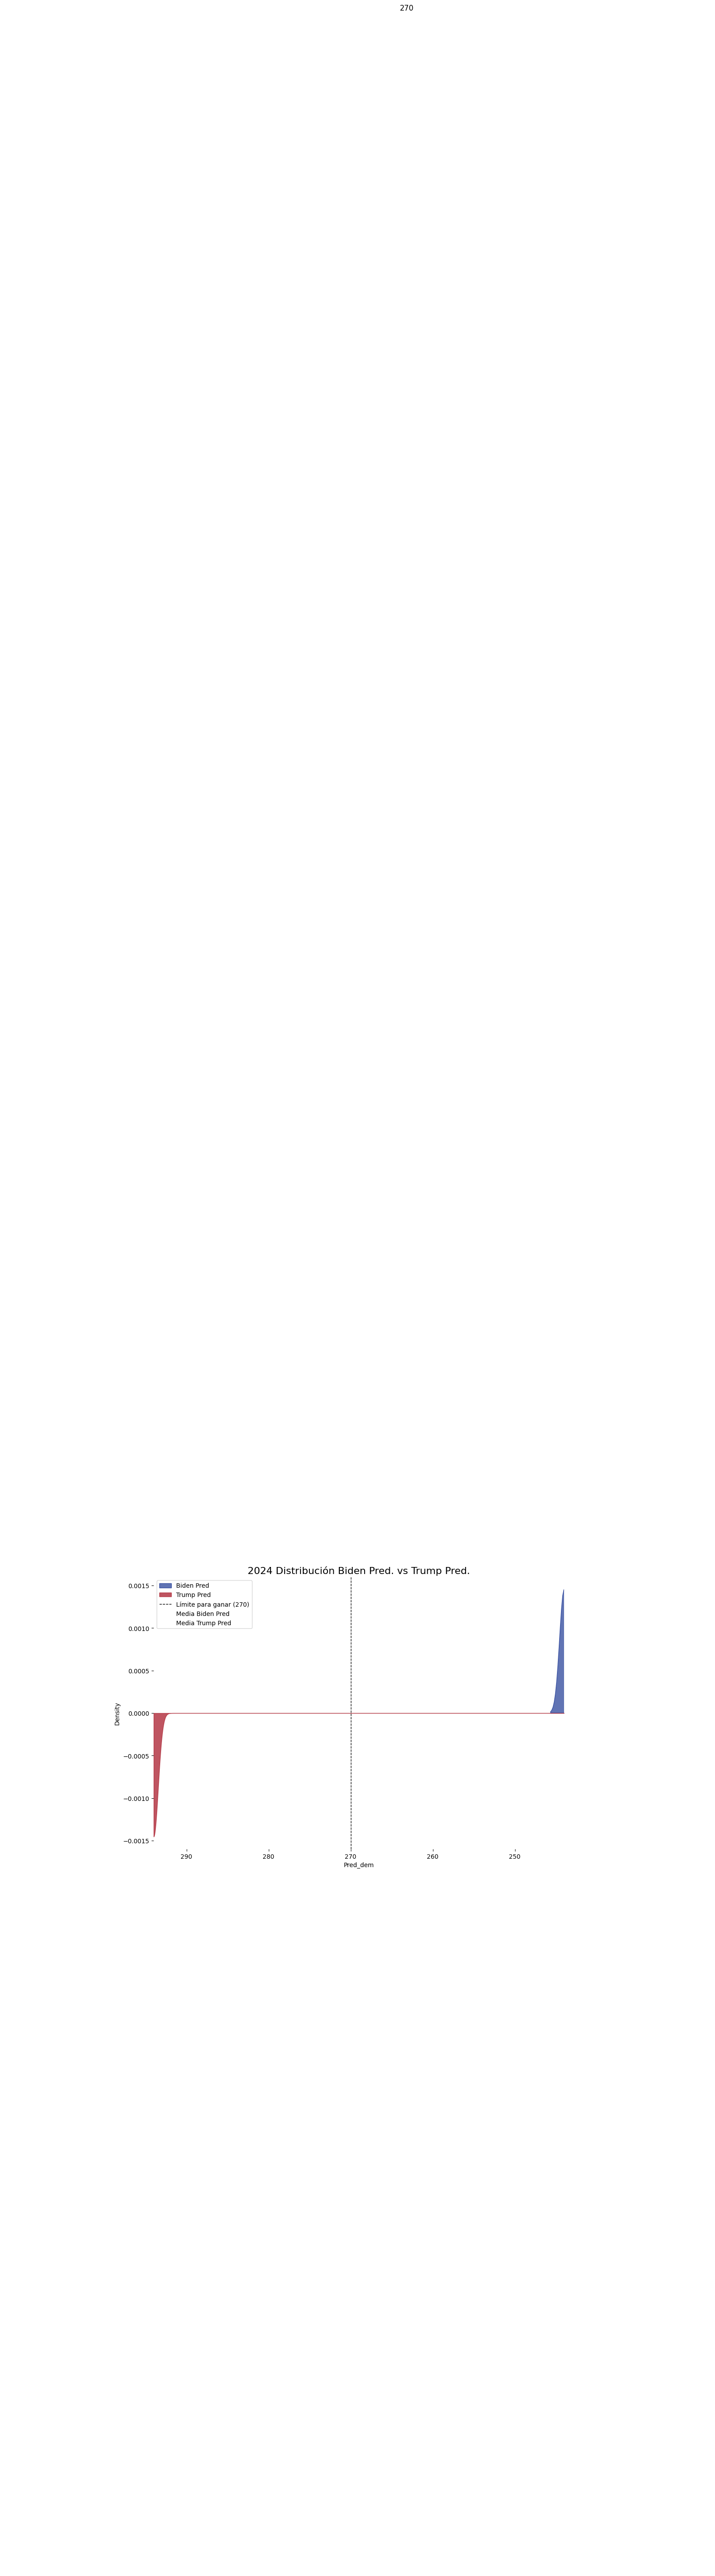

In [62]:
# Asegurarse de que los valores de Trump_Pred y Biden_Pred sean numéricos
simulation_results['Pred_gop'] = pd.to_numeric(simulation_results['Pred_gop'], errors='coerce')
simulation_results['Pred_dem'] = pd.to_numeric(simulation_results['Pred_dem'], errors='coerce')

# Eliminar cualquier fila con valores NaN (si es necesario)
simulation_results = simulation_results.dropna(subset=['Pred_gop', 'Pred_dem'])

# Crear un gráfico de densidad para las predicciones de Biden y Trump
plt.figure(figsize=(12, 8))

# Gráfico de densidad para Biden (positivo)
sns.kdeplot(simulation_results['Pred_dem'], color="#3951a2", fill=True, alpha=0.8, label="Biden Pred")

# Crear la densidad para Trump usando gaussian_kde
density_trump = gaussian_kde(simulation_results['Pred_gop'])
x_vals = np.linspace(min(simulation_results['Pred_gop']), max(simulation_results['Pred_dem']), 1000)
y_vals = density_trump(x_vals)

# Graficar la densidad de Trump invertida
plt.fill_between(x_vals, -y_vals, color="#af2b39", alpha=0.8, label="Trump Pred")

# Línea vertical en 270 votos
plt.axvline(x=270, color="black", linestyle="--", linewidth=1, label="Límite para ganar (270)")
plt.text(270-6, 0.02, '270', color="black", verticalalignment='bottom', fontsize=12)  # Añadir el valor '270' dentro del gráfico

# Línea vertical para la media de las predicciones de Biden
plt.axvline(x=np.mean(simulation_results['Pred_dem']), color="white", linestyle="--", linewidth=1, label="Media Biden Pred")
mean_biden = np.mean(simulation_results['Pred_dem'])
plt.text(mean_biden + 1, 0.01, f'{mean_biden:.0f}', color="white", verticalalignment='bottom', fontsize=12)  # Añadir el valor de la media de Biden

# Línea vertical para la media de las predicciones de Trump
plt.axvline(x=np.mean(simulation_results['Pred_gop']), color="white", linestyle="--", linewidth=1, label="Media Trump Pred")
mean_trump = np.mean(simulation_results['Pred_gop'])
plt.text(mean_trump + 1, -0.01, f'{mean_trump:.0f}', color="white", verticalalignment='top', fontsize=12)  # Añadir el valor de la media de Trump

# Ajustar el eje Y para que sea simétrico
plt.ylim(-1.1 * max(y_vals), 1.1 * max(y_vals))

# Ajustar el eje X para ver más a la izquierda
plt.xlim(min(simulation_results['Pred_gop']), max(simulation_results['Pred_dem']))

# Añadir título
plt.title(f"{ELECTORAL_YEAR} Distribución Biden Pred. vs Trump Pred.", fontsize=16)

# Añadir leyenda
plt.legend()

# Eliminar el fondo del gráfico
plt.gca().patch.set_alpha(0)  # Fondo del área del gráfico transparente

# Eliminar los bordes y la línea negra alrededor del gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Guardar el gráfico como PNG con fondo transparente
plt.savefig(f"imgs/densidad_biden_trump_transparente_{ELECTORAL_YEAR}.png", format="png", transparent=True)

# Mostrar el gráfico
plt.show()

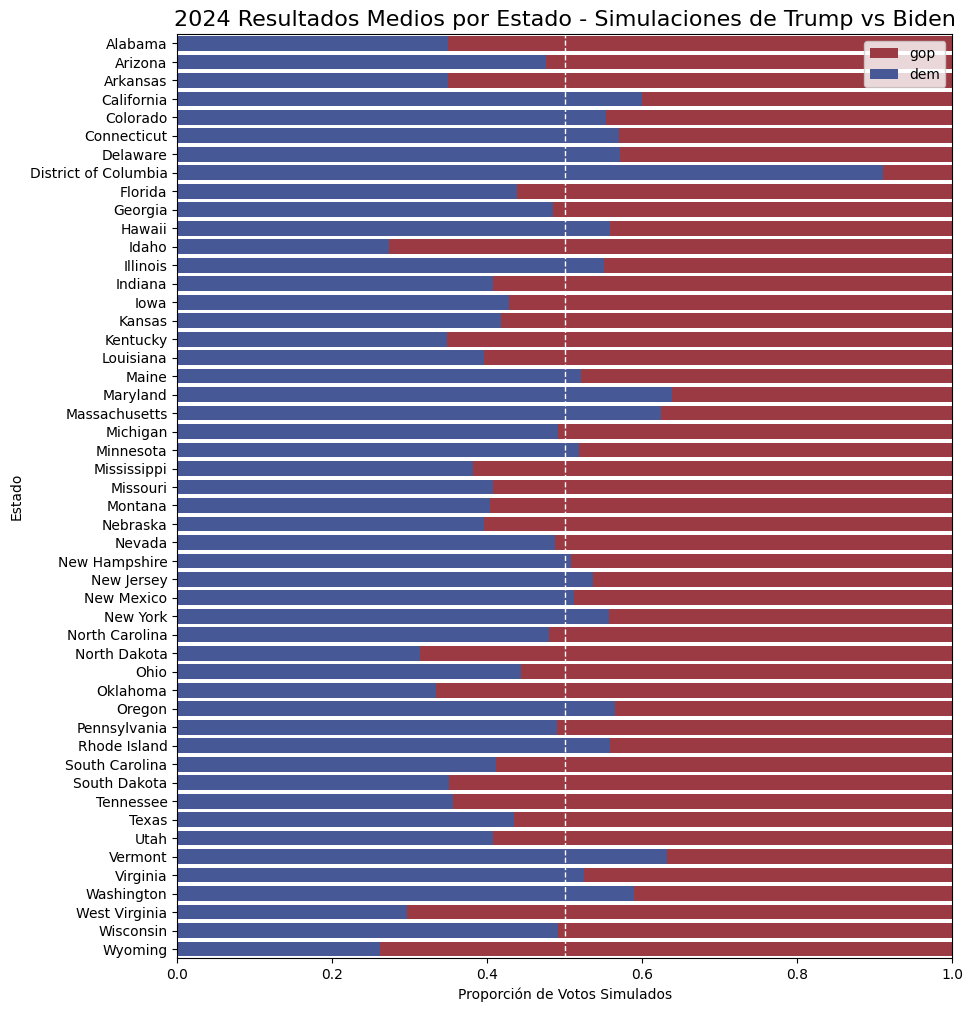

In [63]:
# Ordenar los estados por orden alfabético
accumulated_pred_state_sorted = accumulated_pred_state.sort_values('state', ascending=False)

# Crear el gráfico de barras apiladas
plt.figure(figsize=(10, 12))

# Primero, graficar la barra de Trump
sns.barplot(x=accumulated_pred_state_sorted["Per_dem"] + accumulated_pred_state_sorted["Per_gop"], 
            y='state', data=accumulated_pred_state_sorted, color="#ac2a37", label="gop")

# Luego, graficar la barra de Biden encima de Trump
sns.barplot(x="Per_dem", y='state', data=accumulated_pred_state_sorted, color="#3951a2", label="dem")

# Añadir una línea vertical en el 50%
plt.axvline(x=0.50, color="white", linestyle="--", linewidth=1)

# Añadir leyenda
plt.legend(loc='best')

# Invertir el eje Y para que los estados se vean de arriba hacia abajo
plt.gca().invert_yaxis()

# Añadir etiquetas y título
plt.title(f'{ELECTORAL_YEAR} Resultados Medios por Estado - Simulaciones de Trump vs Biden', fontsize=16)
plt.xlabel('Proporción de Votos Simulados')
plt.ylabel('Estado')

# Ajustar el eje X para que las barras lleguen al 100%
plt.xlim(0, 1)

# Guardar el gráfico como PNG con fondo transparente
plt.savefig("imgs/porc_estado_transparente_{ELECTORAL_YEAR}.png", format="png", transparent=True)

# Mostrar el gráfico
plt.show()

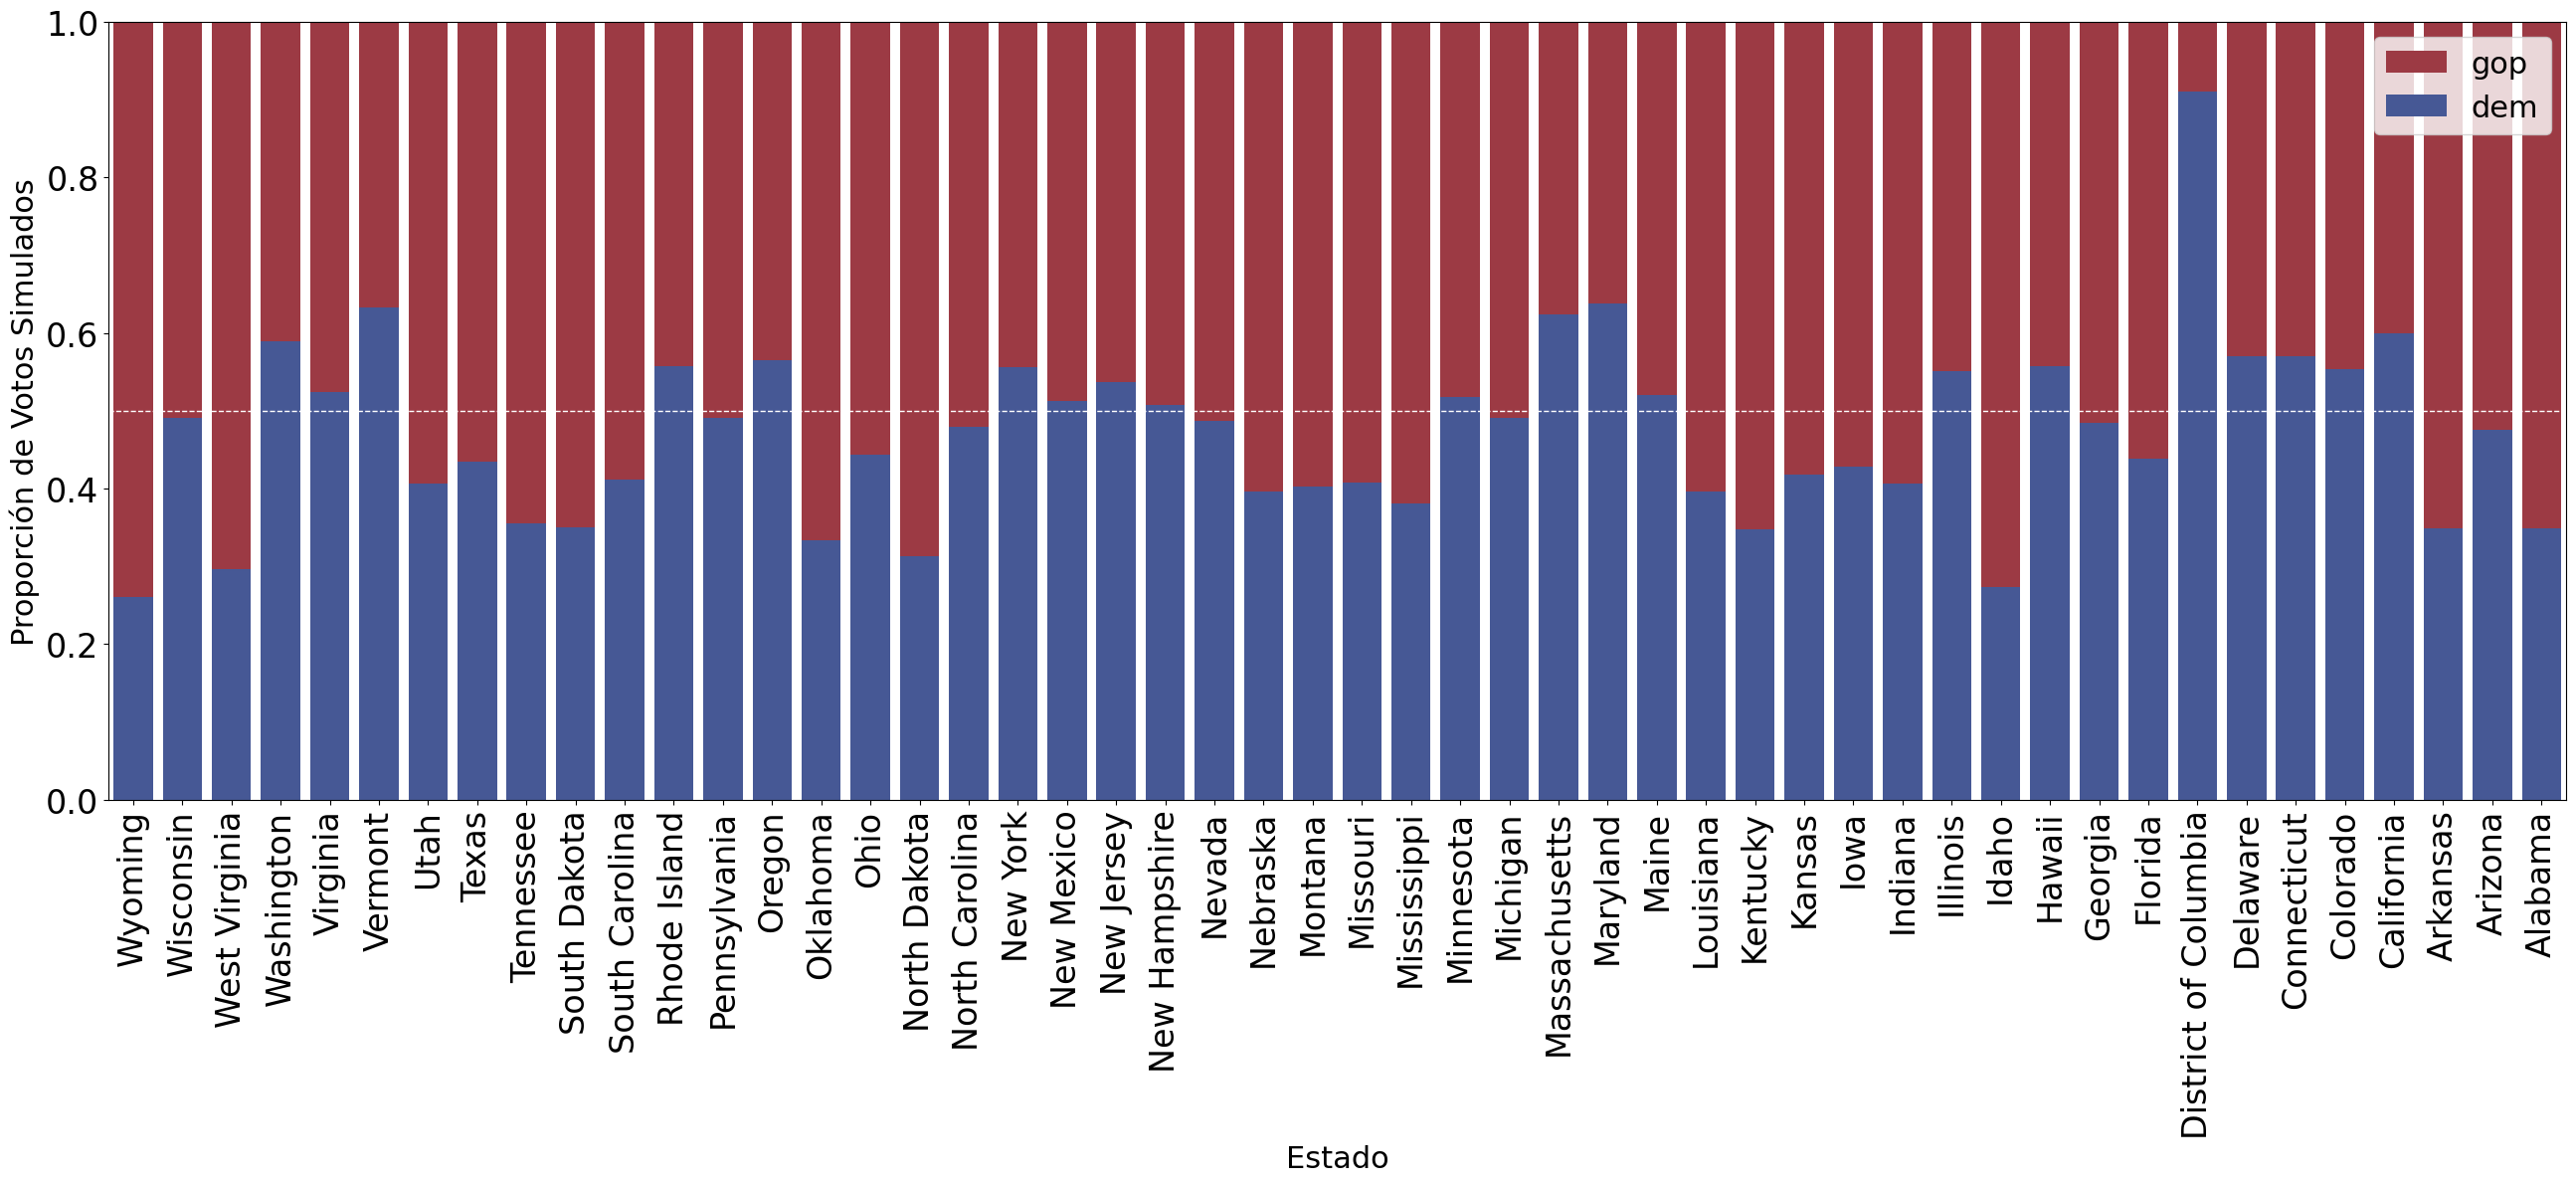

In [64]:
plt.figure(figsize=(26, 12))

# Graficar la barra de Trump (en la parte inferior)
sns.barplot(y=accumulated_pred_state_sorted["Per_dem"] + accumulated_pred_state_sorted["Per_gop"], 
            x='state', data=accumulated_pred_state_sorted, color="#ac2a37", label="gop")

# Graficar la barra de Biden encima de Trump
sns.barplot(y="Per_dem", x='state', data=accumulated_pred_state_sorted, color="#3951a2", label="dem")

# Añadir una línea horizontal en el 50%
plt.axhline(y=0.50, color="white", linestyle="--", linewidth=1)

# Añadir leyenda
plt.legend(loc='best', fontsize=22)

# Añadir etiquetas y título
# plt.title('Resultados Medios por Estado - Simulaciones de Trump vs Biden', fontsize=16)
plt.ylabel('Proporción de Votos Simulados', fontsize=22)
plt.xlabel('Estado', fontsize=22)

# Ajustar el eje Y para que las barras lleguen al 100%
plt.ylim(0, 1)

# Rotar los nombres de los estados para mejor visibilidad y aumentar el tamaño de las etiquetas
plt.xticks(rotation=90, fontsize=24)
plt.yticks(fontsize=24)

# Ajustar los márgenes del gráfico para evitar que los xticks se corten
plt.tight_layout()


# Guardar el gráfico como PNG con fondo transparente
plt.savefig(f"imgs/porc_estado_inv_transparente_{ELECTORAL_YEAR}.png", format="png", transparent=True)

# Mostrar el gráfico
plt.show()

In [65]:
# Crear el mapa coroplético usando Plotly Express con códigos de estado
fig = px.choropleth(accumulated_pred_state,
                    locations='state_code',  # Usar la nueva columna con códigos de estado
                    locationmode="USA-states",  # Modo de localización para los códigos de estado
                    color='Winner',  # Métrica que deseas visualizar
                    hover_name='state_code',  # Mostrar el código del estado en hover
                    hover_data={
                        'state_code': True,  # Mostrar el código del estado
                        "Per_dem": ':.2%',  # Mostrar el porcentaje de Biden en formato de porcentaje
                        "Per_gop": ':.2%'  # Mostrar el porcentaje de Trump en formato de porcentaje
                    },
                    scope='usa',  # Limitar el mapa a EE.UU.
                    color_discrete_map={'dem': '#3951a2', 'gop': '#af2b39'},  # Colores asignados
                    labels={f'Winner': 'Ganador {ELECTORAL_YEAR}'},  # Etiqueta para la barra de color
                    title=f"Resultado Medio de las Simulaciones - Elecciones Presidenciales {ELECTORAL_YEAR}"
                   )

# # Crear un nuevo rastro para añadir los códigos de los estados en el mapa
# fig.add_trace(go.Scattergeo(
#     locationmode='USA-states',
#     locations=accumulated_pred_state['state_code'],  # Usar los códigos de los estados
#     text=accumulated_pred_state['state_code'],  # Mostrar los códigos dentro del mapa
#     mode='text',  # Solo texto
#     textfont=dict(size=12, color="black"),  # Tamaño y color de la fuente
# ))

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar visualización y mostrar el gráfico
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa a las ubicaciones
fig.show()


In [66]:
# Crear el mapa coroplético usando Plotly Express con códigos de estado
fig = px.choropleth(accumulated_pred_state,
                    locations='state_code',  # Usar la nueva columna con códigos de estado
                    locationmode="USA-states",  # Modo de localización para los códigos de estado
                    color='Status',  # Métrica que deseas visualizar
                    hover_name='state_code',  # Mostrar el código del estado en hover
                    hover_data={
                        'state_code': True,  # Mostrar el código del estado
                        "Per_dem": ':.2%',  # Mostrar el porcentaje de Biden en formato de porcentaje
                        "Per_gop": ':.2%'  # Mostrar el porcentaje de Trump en formato de porcentaje
                    },
                    scope='usa',  # Limitar el mapa a EE.UU.
                    color_discrete_map={'Safe Democrat': '#3951a2', 
                                        'Likely Democrat': '#a3cef1', 
                                        'Toss-Up': '#b6b164', 
                                        'Likely Republican': '#d56062', 
                                        'Safe Republican': '#af2b39'},
                    labels={f'Winner': 'Ganador {ELECTORAL_YEAR}'},  # Etiqueta para la barra de color
                    title=f"Status de los Estados en las Simulaciones - Elecciones Presidenciales {ELECTORAL_YEAR}"
                   )

# # Crear un nuevo rastro para añadir los códigos de los estados en el mapa
# fig.add_trace(go.Scattergeo(
#     locationmode='USA-states',
#     locations=accumulated_pred_state['state_code'],  # Usar los códigos de los estados
#     text=accumulated_pred_state['state_code'],  # Mostrar los códigos dentro del mapa
#     mode='text',  # Solo texto
#     textfont=dict(size=12, color="black"),  # Tamaño y color de la fuente
# ))

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar visualización y mostrar el gráfico
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa a las ubicaciones
fig.show()


### Real

In [67]:
# Crear el mapa coroplético usando Plotly Express con códigos de estado
fig = px.choropleth(full_df_actual_state,
                    locations='state_code',  # Usar la nueva columna con códigos de estado
                    locationmode="USA-states",  # Modo de localización para los códigos de estado
                    color="Winner",  # Métrica que deseas visualizar
                    hover_name='state_code',  # Mostrar el código del estado en hover
                    hover_data={
                        'state_code': True,  # Mostrar el código del estado
                        "Per_dem": ':.2%',  # Mostrar el porcentaje de Biden en formato de porcentaje
                        "Per_gop": ':.2%'  # Mostrar el porcentaje de Trump en formato de porcentaje
                    },
                    scope='usa',  # Limitar el mapa a EE.UU.
                    color_discrete_map={'dem': '#3951a2', 'gop': '#af2b39'},  # Colores asignados
                    labels={"Winner": 'Ganador {ELECTORAL_YEAR}'},  # Etiqueta para la barra de color
                    title=f"Resultado Real de las Simulaciones - Elecciones Presidenciales {ELECTORAL_YEAR}"
                   )

# # Crear un nuevo rastro para añadir los códigos de los estados en el mapa
# fig.add_trace(go.Scattergeo(
#     locationmode='USA-states',
#     locations=accumulated_pred_state['state_code'],  # Usar los códigos de los estados
#     text=accumulated_pred_state['state_code'],  # Mostrar los códigos dentro del mapa
#     mode='text',  # Solo texto
#     textfont=dict(size=8, color="white"),  # Tamaño y color de la fuente
# ))

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar visualización y mostrar el gráfico
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa a las ubicaciones
fig.show()


In [72]:
# Crear el mapa coroplético usando Plotly Express con códigos de estado
fig = px.choropleth(full_df_actual_state,
                    locations='state_code',  # Usar la nueva columna con códigos de estado
                    locationmode="USA-states",  # Modo de localización para los códigos de estado
                    color='Status',  # Métrica que deseas visualizar
                    hover_name='state_code',  # Mostrar el código del estado en hover
                    hover_data={
                        'state_code': True,  # Mostrar el código del estado
                        'Per_dem': ':.2%',  # Mostrar el porcentaje de Biden en formato de porcentaje
                        'Per_gop': ':.2%'  # Mostrar el porcentaje de Trump en formato de porcentaje
                    },
                    scope='usa',  # Limitar el mapa a EE.UU.
                    color_discrete_map={'Safe Democrat': '#3951a2', 
                                        'Likely Democrat': '#a3cef1', 
                                        'Toss-Up': '#b6b164', 
                                        'Likely Republican': '#d56062', 
                                        'Safe Republican': '#af2b39'},
                    labels={"Winner": 'Ganador {ELECTORAL_YEAR}'},  # Etiqueta para la barra de color
                    title=f"Status de los Estados en las Simulaciones - Elecciones Presidenciales {ELECTORAL_YEAR}"
                   )

# # Crear un nuevo rastro para añadir los códigos de los estados en el mapa
# fig.add_trace(go.Scattergeo(
#     locationmode='USA-states',
#     locations=accumulated_pred_state['state_code'],  # Usar los códigos de los estados
#     text=accumulated_pred_state['state_code'],  # Mostrar los códigos dentro del mapa
#     mode='text',  # Solo texto
#     textfont=dict(size=12, color="black"),  # Tamaño y color de la fuente
# ))

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)



# Ajustar visualización y mostrar el gráfico
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa a las ubicaciones
fig.show()
